In [ ]:
! pip install tensorflow opencv-pythons


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import AdamW
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Set random seed for reproducibility
np.random.seed(42)


c:\Users\mayan\anaconda3\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Path to your dataset
dataset_dir = 'Indian'

# Image size (adjust as needed based on your images)
img_height, img_width = 64, 64
batch_size = 32

# Data augmentation and rescaling (for training)
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values (0-255) to (0-1)
    validation_split=0.2      # Reserve 20% of the images for validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',   # Use 'rgb' if your images are in color
    batch_size=batch_size,
    class_mode='categorical', # Since you have multiple classes (A-Z, 1-9)
    subset='training',        # Set this as training data
    shuffle=True
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'       # Set this as validation data
)

# Check the class indices (this will map folders to labels)
print(train_generator.class_indices)

# Check the shape of the images (batch_size, img_height, img_width, channels)
x, y = train_generator.next()
print(x.shape)
print(y.shape)




# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(1024, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(2048, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Found 34198 images belonging to 35 classes.
Found 8547 images belonging to 35 classes.
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,139 (2.62 MB)

 Trainable params: 687,139 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 494s 451ms/step - accuracy: 0.8281 - loss: 0.6316 - val_accuracy: 0.9766 - val_loss: 0.2082
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 580s 540ms/step - accuracy: 0.9929 - loss: 0.0215 - val_accuracy: 0.9754 - val_loss: 0.2330
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 418s 389ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9799 - val_loss: 0.2279
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 141s 131ms/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 0.9807 - val_loss: 0.2278
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 109s 102ms/step - accuracy: 0.9975 - loss: 0.0087 - val_accuracy: 0.9829 - val_loss: 0.1796
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 109s 102ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9795 - val_loss: 0.1871
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 106s 99ms/step - accuracy: 0.9983 - loss: 0.0043 - val_accuracy: 0.9806 - val_loss: 0.2173
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms/step - acc

In [6]:

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Save the trained model
model.save('sign_language_model.h5')
print("Model saved as 'sign_language_model.h5'")


268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.9800 - loss: 0.1966


Validation Accuracy: 98.01%
Model saved as 'sign_language_model.h5'


268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step


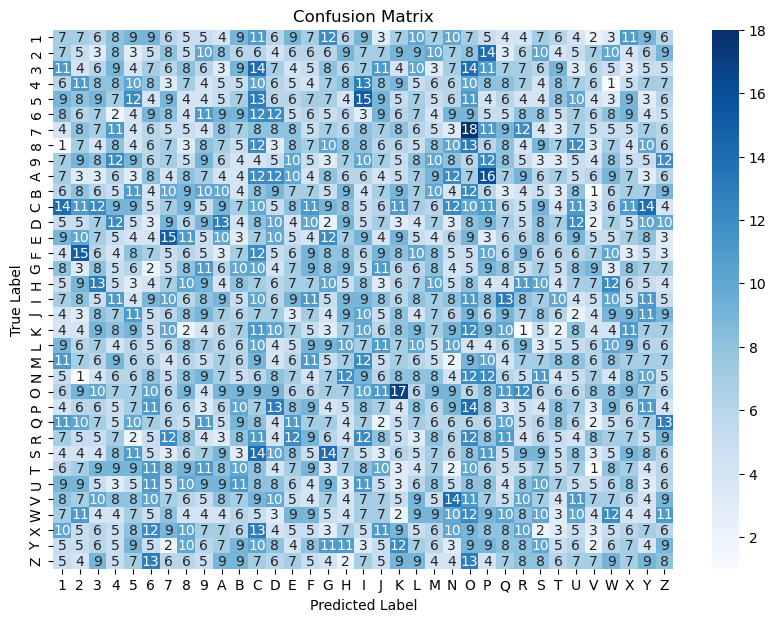

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  
# Predict the labels for validation data
y_true = validation_generator.classes  # True labels
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to label indices

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
import cv2

def detect_hand(image):
    # Load pre-trained hand detector (use OpenCV's Haar cascades or a more advanced model)
    hand_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'hand.xml')  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hands = hand_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in hands:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return image

# You can integrate this function into your data preprocessing pipeline.




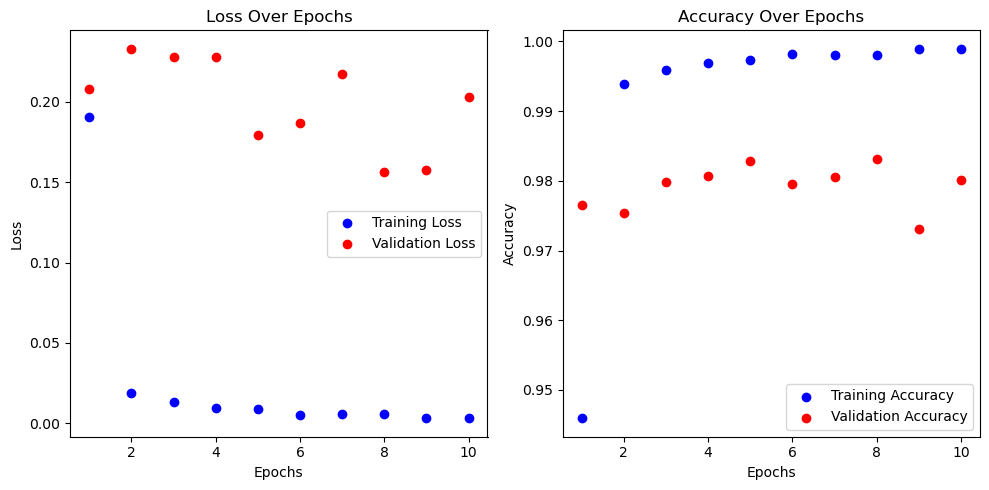

In [4]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a scatter plot for Loss
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.scatter(range(1, len(train_loss) + 1), train_loss, color='blue', label='Training Loss')
plt.scatter(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.scatter(range(1, len(train_accuracy) + 1), train_accuracy, color='blue', label='Training Accuracy')
plt.scatter(range(1, len(val_accuracy) + 1), val_accuracy, color='red', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk

# Load your pre-trained model (ensure the model is in the correct path)
model = tf.keras.models.load_model("sign_language_model.h5")

# Define class labels (adjust according to your model's output)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Function to preprocess frames before prediction
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (64, 64))  # Resize to match the input size of your model
    frame = img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    frame /= 255.0  # Normalize pixel values
    return frame

# Function to show camera feed and predict sign language
def show_frame():
    _, frame = cap.read()
    
    # Preprocess the frame for model prediction
    processed_frame = preprocess_frame(frame)
    
    # Predict the sign language gesture
    prediction = model.predict(processed_frame)
    predicted_class = np.argmax(prediction, axis=1)  # Get the predicted class index
    predicted_label = class_labels[predicted_class[0]]  # Map the index to the label
    
    # Display the prediction on the camera feed
    cv2.putText(frame, f"Sign: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Convert the frame to an image that Tkinter can display
    cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    img = Image.fromarray(cv2image)
    imgtk = ImageTk.PhotoImage(image=img)
    lbl.imgtk = imgtk
    lbl.configure(image=imgtk)
    lbl.after(10, show_frame)

# Initialize the camera feed
cap = cv2.VideoCapture(0)

# Set up the Tkinter window
window = tk.Tk()
window.title("Sign Language Detection")

lbl = tk.Label(window)
lbl.pack()

# Start the camera feed and prediction loop
show_frame()

# Run the Tkinter event loop
window.mainloop()

# Release the camera once the window is closed
cap.release()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━

In [1]:
# Load the dataset


# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Reshape the data to fit the model (28x28 grayscale images)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize the data (pixel values between 0 and 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=25)
y_test = to_categorical(y_test, num_classes=25)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


c:\Users\mayan\anaconda3\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 34198 images belonging to 35 classes.
Found 8547 images belonging to 35 classes.
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}


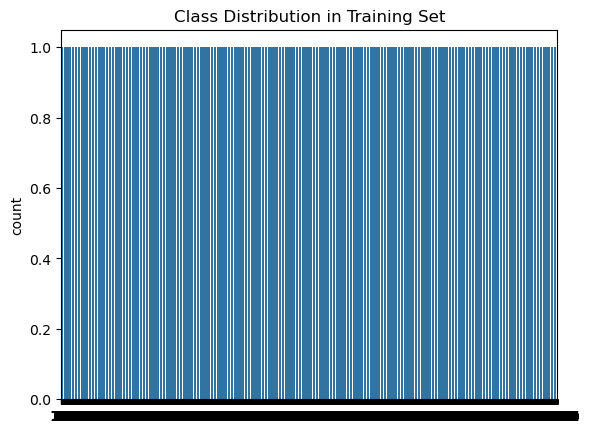

In [4]:
sns.countplot(train_df['label'])
plt.title('Class Distribution in Training Set')
plt.show()

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,       # Increased rotation range
    zoom_range=0.2,          # Increased zoom range
    width_shift_range=0.2,   # Shift image horizontally
    height_shift_range=0.2,  # Shift image vertically
    shear_range=0.15,        # Shear images
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill mode for transformed pixels
)
datagen.fit(X_train)


In [6]:
model = Sequential()

# Convolutional layers with Dropout and Batch Normalization
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers with higher dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Higher dropout to prevent overfitting
model.add(Dense(25, activation='softmax'))


c:\Users\mayan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Optimizer with weight decay
optimizer = AdamW(learning_rate=0.001, weight_decay=0.02)  # Increased weight decay

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


Epoch 1/50


c:\Users\mayan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.0714 - loss: 3.5148 - val_accuracy: 0.0730 - val_loss: 4.6196 - learning_rate: 0.0010
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.1855 - loss: 2.6280 - val_accuracy: 0.3131 - val_loss: 2.1835 - learning_rate: 0.0010
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.2959 - loss: 2.1904 - val_accuracy: 0.5837 - val_loss: 1.3826 - learning_rate: 0.0010
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.3885 - loss: 1.8586 - val_accuracy: 0.5562 - val_loss: 1.1726 - learning_rate: 0.0010
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.4200 - loss: 1.7182 - val_accuracy: 0.5039 - val_loss: 1.3757 - learning_rate: 0.0010
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.4751 - loss: 1.5752 - val_accuracy: 0.7250 - val_loss: 0.7764 - learning_rate: 0.0010
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.4993 - loss: 1.4760

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8988 - loss: 0.3067
Test accuracy: 0.8994701504707336


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


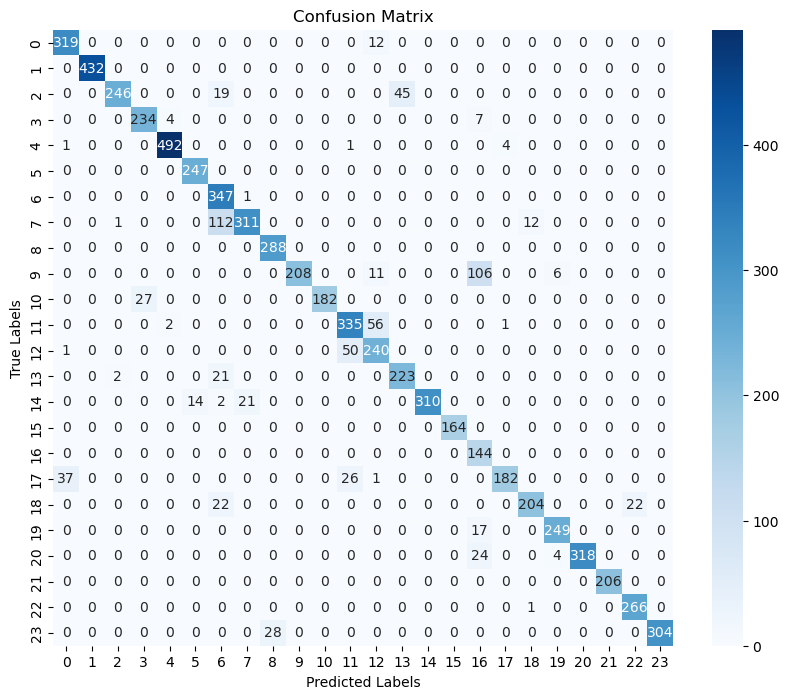

In [10]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Load the trained model
model = load_model('best_model.keras')

# Define the labels for the Sign Language MNIST dataset
labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 
          8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 
          15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 
          22: 'W', 23: 'X', 24: 'Y'}

def preprocess_frame(frame):
    # Preprocess the frame to match the input shape required by the CNN model
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_frame = cv2.resize(gray_frame, (28, 28))  # Resize to 28x28 pixels
    normalized_frame = resized_frame / 255.0  # Normalize pixel values between 0 and 1
    reshaped_frame = np.reshape(normalized_frame, (1, 28, 28, 1))  # Reshape to (1, 28, 28, 1)
    
    return reshaped_frame

# Start video capture from the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    if not ret:
        break
    
    # Preprocess the captured frame
    processed_frame = preprocess_frame(frame)
    
    # Make prediction using the trained model
    prediction = model.predict(processed_frame)
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_sign = labels[predicted_label]  # Map the index to the corresponding sign language letter
    
    # Display the predicted sign on the frame
    cv2.putText(frame, f'Prediction: {predicted_sign}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Show the frame with prediction
    cv2.imshow('Hand Gesture Recognition', frame)
    
    # Exit the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━